# Instructions
1. Si vous utilisez Google Colab,Mettre TPU dans le mode d'execution. (Execution -> modifier le type d'execution -> TPU)
2. Mettre les photos que vous voulez analyser dans le repertoire où se trouve le notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%ls

drive/  sample_data/  tpu/


## Telecharger le code source du modele Mask R-CNN



In [2]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 9603 (delta 11), reused 12 (delta 4), pack-reused 9576
Receiving objects: 100% (9603/9603), 24.21 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (6873/6873), done.


On doit installer opencv contrib pour utiliser **sift**

In [3]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 174kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 147kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## Import libraries

In [4]:
from IPython import display
from PIL import Image
import cv2
import numpy as np
import pandas as pd
%tensorflow_version 1.x
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils
from skimage.measure import compare_ssim
import imutils

TensorFlow 1.x selected.


## Charger la dataset COCO
Dans cette base de données chaque objet pouvant être détecté par COCO est associé à un chiffre. Lorsque vous passerez votre image dans le modèle il vous ressortira une image avec les objets encadré par le champ qu'il a détécté.

In [5]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Chargement d'une image


In [25]:
image_path='/content/drive/My Drive/projet_immo2/app_immo/static/'
image_path_im = '/content/drive/My Drive/projet_immo2/app_immo/static/photo_salle_de_bain-2.jpg' #mettre le chemin d'acces de la photo qui se trouve dans le repertoire.

with open(image_path_im, 'rb') as f:
  np_image_string = np.array([f.read()])
image = Image.open(image_path_im)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

#display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Ici si vous êtes sur google colab vous pouvez selectionner le TPU si vous faites tourner sur un CPU decocher la case use_tpu. L'utilisation d'un TPU permettre de faire les calculs plus rapidement.

In [9]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.118.170.154:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 16394516706925758540),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3855531263478727599),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4259930892203784826),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17614944820280067424),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 15160836212389145822),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 10106181493294888410),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 9610629512128935135),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12298710277532801798),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 180984622

# Chargement du modèle sauvegardé prétraité COCO depuis le seau public GCS.



In [10]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [26]:

num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
#print(detection_boxes)
#print(num_detections)
#print(detection_scores)
#print(detection_classes)


## Visualize the detection results
Time to check out the result!

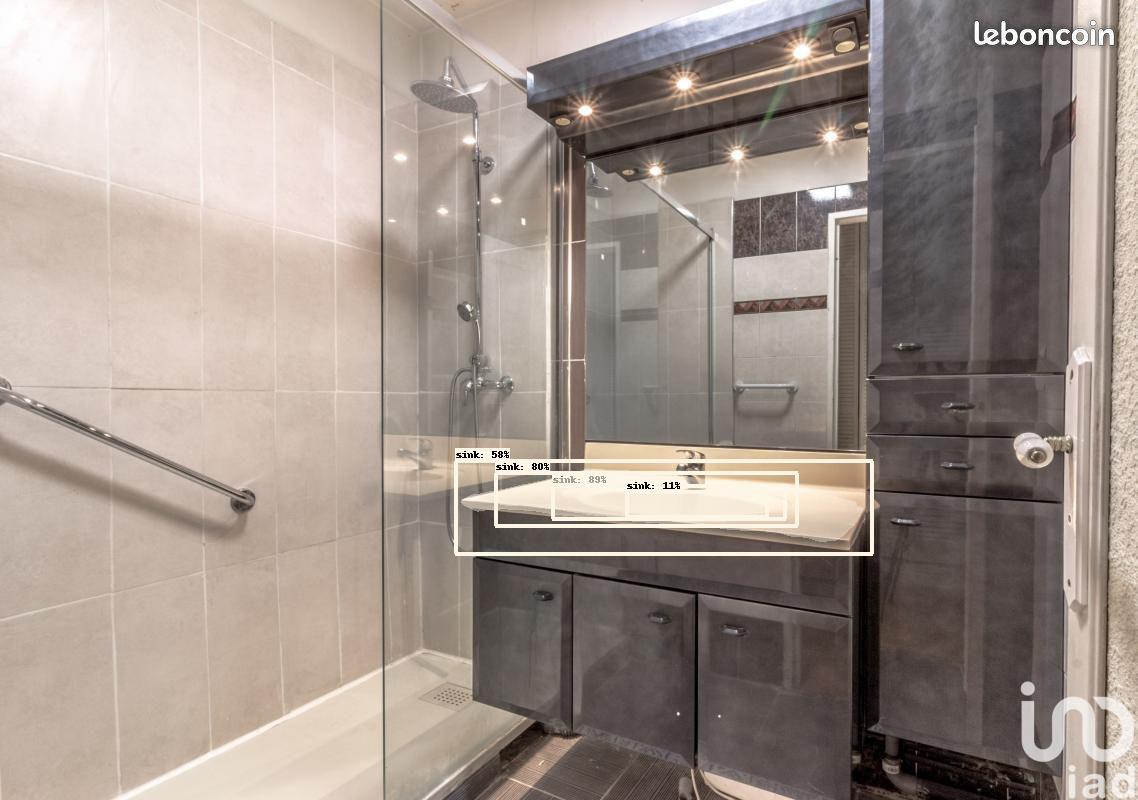

In [27]:
max_boxes_to_draw =    50#@param {type:"integer"}
min_score_thresh = 0.10   #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# **Factorisation du code pour appliquer à plusieurs images**

**Cette partie recupere les images du repertoire courant. Il faudra remplacer /content par le chemin du dossier dans lequel vous avez vos images**

In [50]:
liste_fichier=os.listdir('/content/drive/My Drive/projet_immo2/app_immo/static/')
liste_image=[]
for x in liste_fichier:
  if x.endswith('.jpg') and x.startswith('photo'):
    liste_image.append(x)
print(liste_image)

['photo_chambre-2.jpg', 'photo_chambre2-2.jpg', 'photo_couloir-2.jpg', 'photo_cuisine-2.jpg', 'photo_salle_de_bain-2.jpg', 'photo_salon-2.jpg']


**Cette fonction va effectuer l'emboxing des objets détectés par le modele. On recupere à l'interieur de liste_detection les informations des objets detectées de l'image passée en parametre**

In [56]:
def detection(image,liste_detection):
  print(image_path+image)
  with open(image_path+image, 'rb') as f:
    np_image_string = np.array([f.read()])
  image1 = Image.open(image_path+image)
  width, height = image1.size
  np_image = np.array(image1.getdata()).reshape(height, width, 3).astype(np.uint8)

  num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
  ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
  feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
  #print(detection_boxes)
  #print(num_detections)
  #print(detection_scores)
  #print(detection_classes)
  liste_detection.append((image_path+image,detection_scores,detection_classes,detection_boxes))
  max_boxes_to_draw =    50#@param {type:"integer"}
  min_score_thresh = 0.6  #@param {type:"slider", min:0, max:1, step:0.01}

  image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
  np_image,
  detection_boxes,
  detection_classes,
  detection_scores,
  category_index,
  instance_masks=segmentations,
  use_normalized_coordinates=False,
  max_boxes_to_draw=max_boxes_to_draw,
  min_score_thresh=min_score_thresh)
  output_image_path = image_path+'test'+image
  Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
  display.display(display.Image(output_image_path, width=1024))




**On applique le mask rcnn sur toutes les images du dossier**

photo_chambre-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_chambre-2.jpg


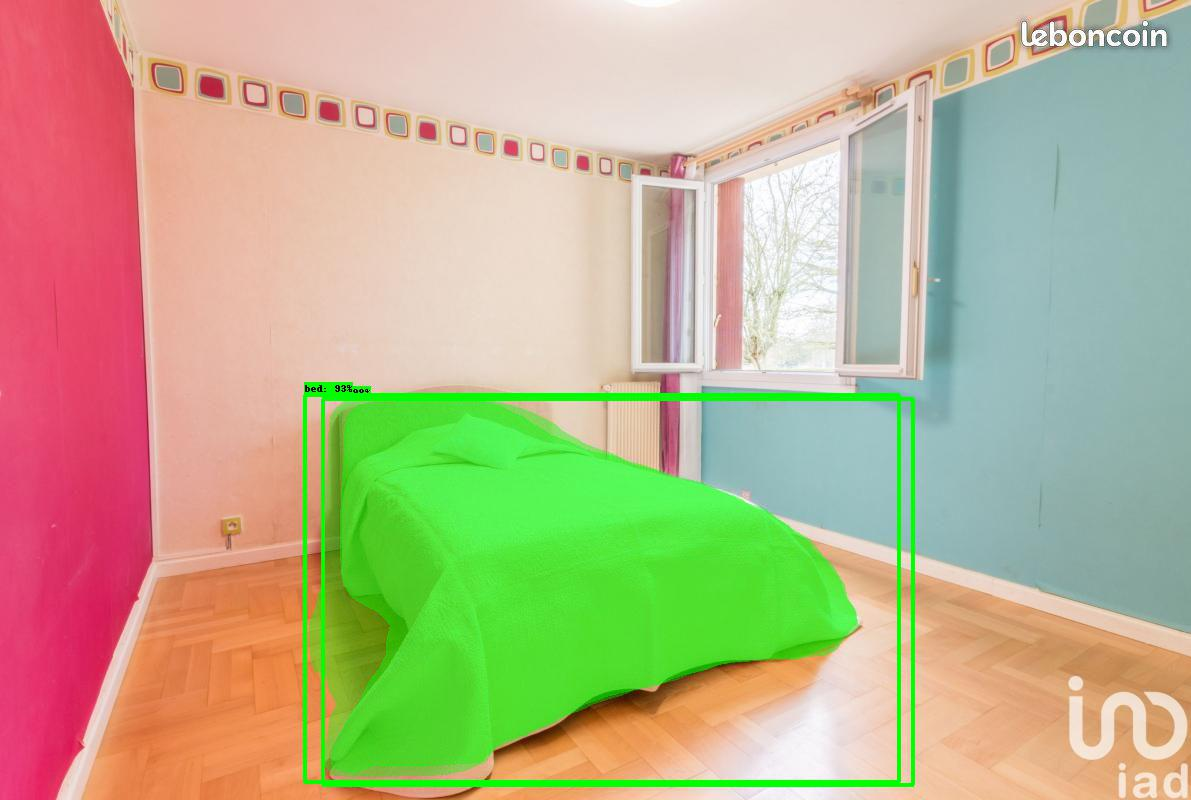

photo_chambre2-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_chambre2-2.jpg


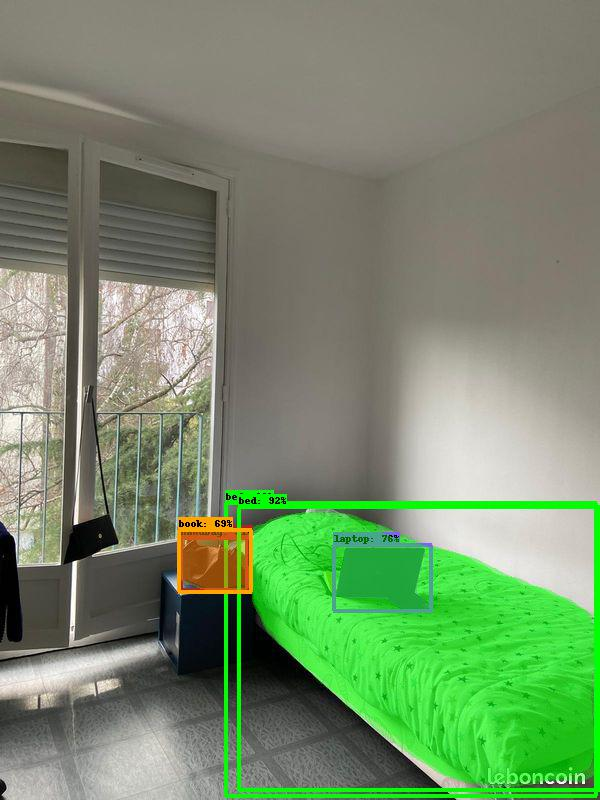

photo_couloir-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_couloir-2.jpg


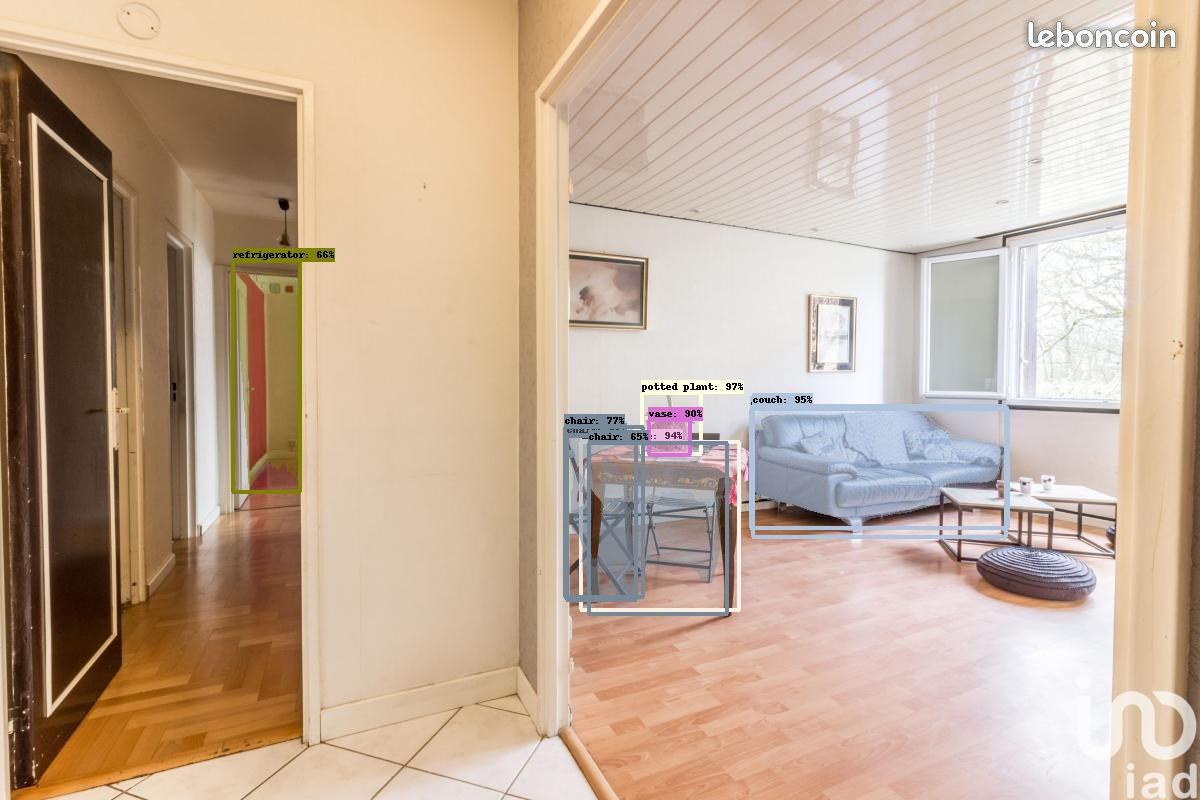

photo_cuisine-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_cuisine-2.jpg


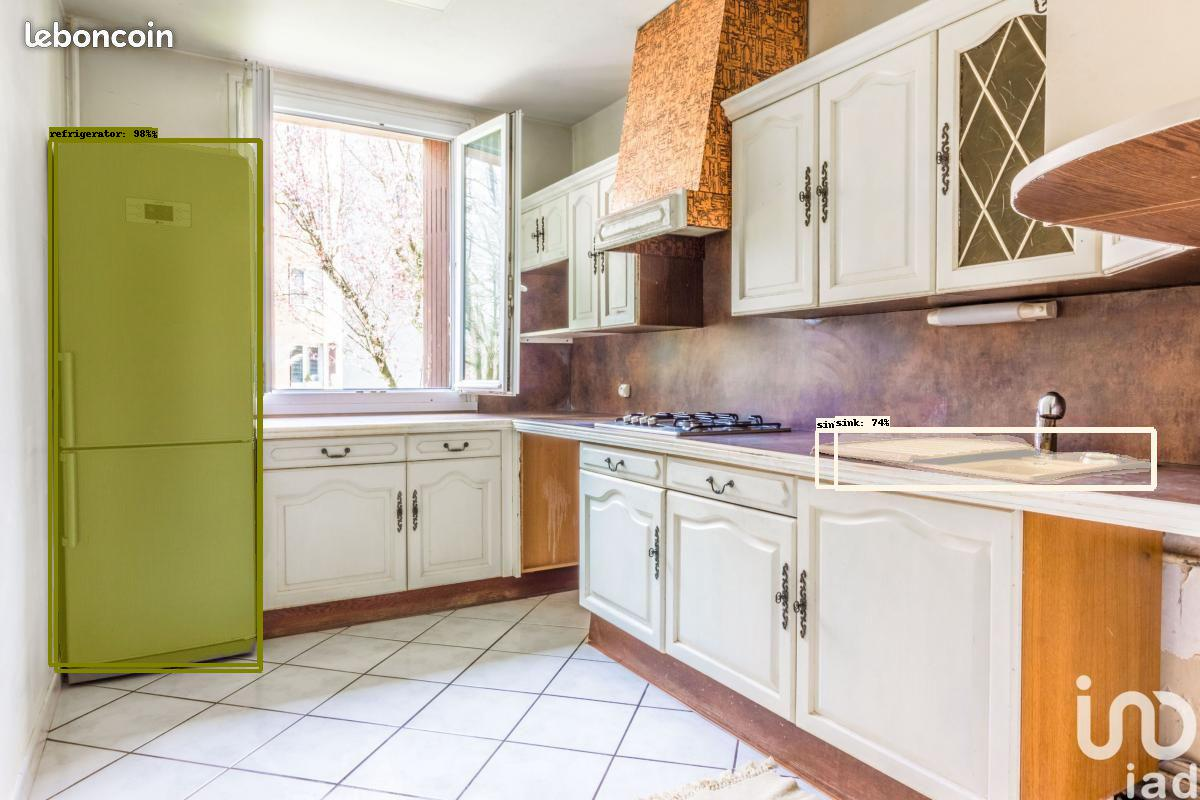

photo_salle_de_bain-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_salle_de_bain-2.jpg


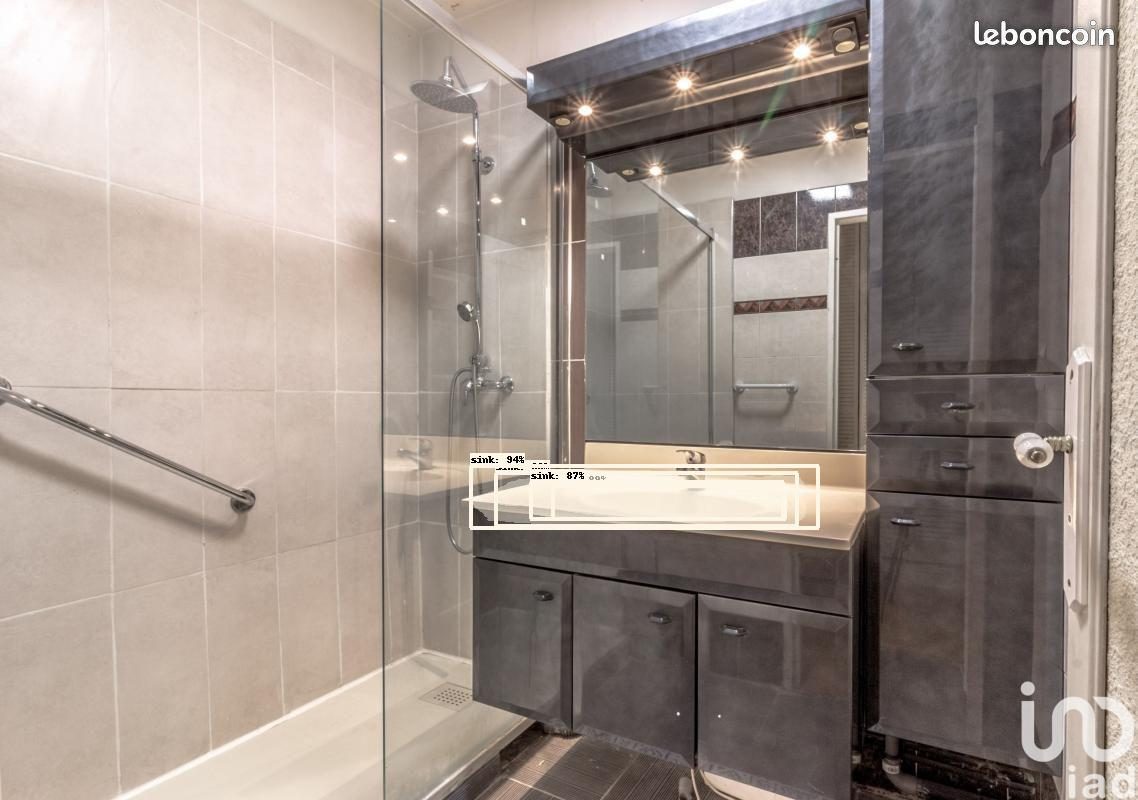

photo_salon-2.jpg
/content/drive/My Drive/projet_immo2/app_immo/static/photo_salon-2.jpg


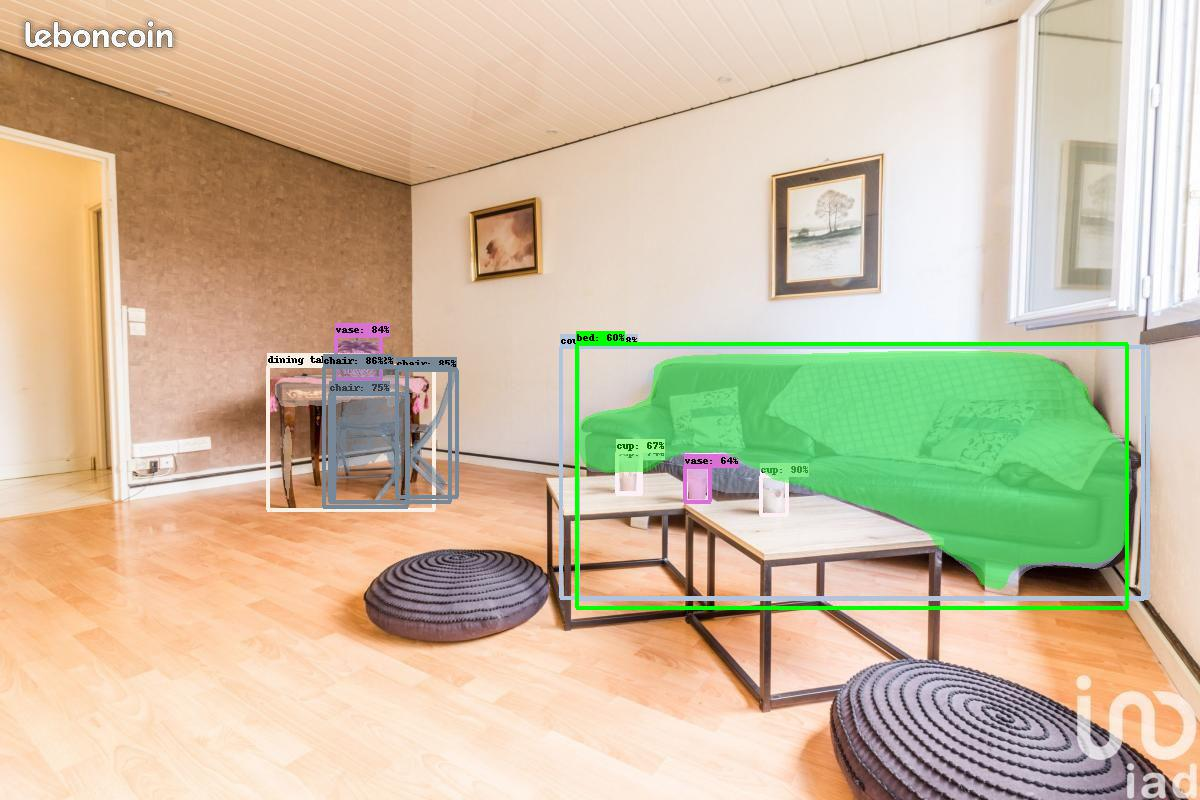

In [58]:
liste_detection=[]

for image in liste_image:
  print(image)
  detection(image,liste_detection)

**liste des objets de la dataset COCO qui peuvent etre presents dans les differentes pieces. Pour pouvoir avoir plus de précision sur les différentes pièces detectées il aurait fallu ajouter des nouveaux item dans la dataset en faisant du transfert learning**

In [59]:
liste_salon=[47,62,63,67,72,31,64,73,74,75,76,77,84,85,86]
liste_cuisine=[47,79,80,81,82,78]
liste_chambre=[65,31,32,33,88,85,84,77,76,75,74,73,72]
liste_salle_de_bain=[81,89,90,70]
liste_toilette=[70]
liste_objet=[31,32,33,47,62,63,64,65,67,70,72,73,74,75,76,77,78,79,80,81,82,84,85,86,89,90]


**Fonction qui permet de recuperer le nom de la piece grace aux objets qui s'y trouve**

In [60]:

def identification_piece(liste_element_detec,liste_piece_annonce):
  objet=liste_element_detec[2]
  score=liste_element_detec[1]
  liste_piece=['salon','cuisine','chambre','salle de bain','toilette','autre']
  piece=[0,0,0,0,0,0]
  count,i=0,0
  detection_ok,detection_score_ok=[],[]
  for i in range(0,len(objet)):
    if (score[i]>0.7):
      detection_ok.append(objet[i])
      detection_score_ok.append(score[i])
    detection_ok= pd.Series(detection_ok).drop_duplicates().tolist()
  print(detection_ok)
  print(detection_score_ok)
  if (81 in detection_ok):
    for x in liste_cuisine:
      if x!=81 and x in detection_ok:
        piece[1]+=1
    if piece[1]==0:
      for y in liste_salle_de_bain:
        if x!=81 and x in detection_ok:
          piece[3]+=1
    if piece[1]==0 and piece[3]==0:
      piece[5]+=1
  else: 
    for i in range(0,len(detection_ok)):
      if (objet[i] in liste_salon):
        piece[0]+=1
      if objet[i] in liste_cuisine:
        piece[1]+=1
      if objet[i] in liste_chambre:
        piece[2]+=1
      if objet[i] in liste_salle_de_bain:
        piece[3]+=1
      if objet[i] in liste_toilette:
        piece[4]+=1
      if (objet[i] in liste_objet)== False:
        piece[5]+=1
  print(liste_piece[piece.index(max(piece))])
  liste_piece_annonce.append((liste_element_detec,liste_piece[piece.index(max(piece))]))


**La fonction nombre_pièce affiche le nombre de pièce d'un bien à partir de la liste crée par la fonction identification_piece. Il faut savoir que l'on compte seulement les chambres et salon lorsqu'on donne un nombre de pièce.**

In [61]:
liste_piece_annonce=[]
for element in liste_detection:
  identification_piece(element,liste_piece_annonce)

liste_finale=[]

def nombre_piece(liste_piece_annonce,liste_piece_finale):
  nombre_piece=0
  liste_piece_finale=[]
  for piece in liste_piece_annonce:
    if piece[1] not in liste_piece_finale or piece[1]!='salon':
      liste_piece_finale.append(piece[1])
      if piece[1]=='chambre' or piece[1]=='salon':
        nombre_piece+=1
  print(f'il y a {nombre_piece} pieces dans ce bien')
      


nombre_piece(liste_piece_annonce,liste_finale)

[65]
[0.93522]
chambre
[65]
[0.9291519]
chambre
[63, 62]
[0.9595456, 0.77371013]
salon
[82, 81]
[0.98982084, 0.7476114]
cuisine
[81]
[0.94553685, 0.871618]
autre
[63, 62]
[0.8693569, 0.86416644]
salon
il y a 3 pieces dans ce bien


## **Partie sur le dedoublement d'image**

In [62]:
annonce1="/content/drive/My Drive/projet_immo2/app_immo/static/photo_chambre.jpg"
annonce2="/content/drive/My Drive/projet_immo2/app_immo/static/photo_chambre2.jpg"
annonce3="/content/drive/My Drive/projet_immo2/app_immo/static/photo_couloir.jpg"
annonce4="/content/drive/My Drive/projet_immo2/app_immo/static/photo_couloirphoto_salon.jpg"

**Cette fonction permet de comparer deux images grace à la fonction compare_ssim qui compare pixel par pixel.**

In [63]:
def comp_image(im1,im2):
	Im1 = cv2.imread(im1)
	Im2 = cv2.imread(im2)
	Im2=cv2.resize(Im2,(Im1.shape[1],Im1.shape[0]))
	grayA = cv2.cvtColor(Im1, cv2.COLOR_BGR2GRAY)
	grayB = cv2.cvtColor(Im2, cv2.COLOR_BGR2GRAY)
	(score, diff) = compare_ssim(grayA, grayB, full=True)
	diff = (diff * 255).astype("uint8")
	#print("SSIM: {}".format(score))
	return score


print(comp_image(annonce1,annonce2))
print(comp_image(annonce3,annonce4))

0.4937976957001895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  import sys


error: ignored

**Cette fonction compare deux images grâce à leur point d'interet**

The images have same size and channels
The images are not equal
0.5377942998760843


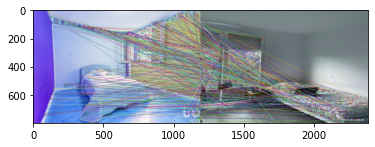

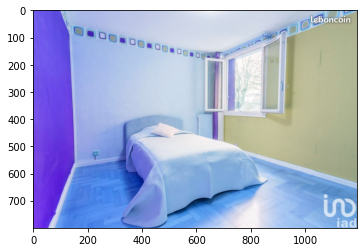

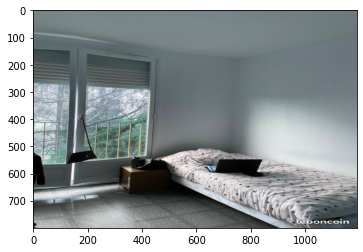

In [ ]:
def comp_image2(annonce1,annonce2):
  annonce1=cv2.imread(annonce1)
  annonce2=cv2.imread(annonce2)
  annonce2=cv2.resize(annonce2,(annonce1.shape[1],annonce1.shape[0]))
  #verifie si 2 images sont egales
  if (annonce1.shape== annonce2.shape):
    print("The images have same size and channels")
    difference=cv2.subtract(annonce1,annonce2)
    b,g,r =cv2.split(difference)
    if (cv2.countNonZero(b)==0 and cv2.countNonZero(g)==0 and cv2.countNonZero(r)==0):
      print("The images are completely Equal")
    else: 
      print("The images are not equal")
  sift = cv2.xfeatures2d.SIFT_create()
  kp_1, desc_1 = sift.detectAndCompute(annonce1, None)
  kp_2, desc_2 = sift.detectAndCompute(annonce2, None)
  index_params = dict(algorithm=0, trees=5)
  search_params = dict()
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(desc_1, desc_2, k=2)
  good_points = []
  ratio = 0.96
  for m, n in matches:
    if m.distance < ratio*n.distance:
      good_points.append(m)
      #print(len(good_points))
  result = cv2.drawMatches(annonce1, kp_1,annonce2, kp_2, good_points, None)
  print(len(good_points)/len(matches))
  plt.imshow(result)
  plt.show()
  plt.imshow(annonce1)
  plt.show()
  plt.imshow(annonce2)
  plt.show()

comp_image2(annonce1,annonce2)

